In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.cm as cm
%matplotlib inline
import cmocean
import plotting
from takeout import monthly_means_annual

import copy

In [2]:
# constant declarations
#lat1 < lat2
lat1 = -30
lat2 = 30

lat_lims = [lat1,lat2]


#variable files on disk
omega_file_full = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/mergeFiles/w_7917.nc'


lon_list = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 239]

#lon_list_labels = ["180W", "150W", "120W", "90W", "60W", "30W", "0", "30E", "60E", "90E", "120E", "150E", "180E"]
lon_list_labels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5]

shifted_lon_list = [60, 80, 100, 120, 140, 160, 180, 200, 220, 239, 0, 20, 40]
shifted_lon_list_labels = [90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5, 0, 30, 60]
shifted_labels_eastWest = ['90E', '120E', '150E', '180', '150W', '120W', '90W', '60W', '30W', '0', '30E', '60E', '90E']

#ytick_list = [36, 25, 21, 17, 14, 10, 9]
p_tick_list = [0, 1, 5, 8, 12, 16, 28]
p_list = [70, 100, 200, 300, 500, 700, 1000]
z_list = [5, 10, 15, 20, 25]

#for plotting
vmin = -0.0325
vmax = 0.035
contours = np.arange(vmin, vmax, 0.0025)

colormap = cmocean.cm.balance
colorbar_label = r"$hPa \hspace{1} s^{-1} \hspace{1} m^{-2}$"

djf = 'DJF '
mam = 'MAM '
jja = 'JJA '
son = 'SON '
left_title_u = '$-\omega$ Mask, '
left_title_d = '$\omega$ Mask, '
lat_band = str(lat_lims)

#need to change season string here
left_title_up = djf+left_title_u+lat_band
left_title_down = djf+left_title_d+lat_band

#It is actually omega, but weighted for regions where it is upward(or negative) between x˚S and x˚N.
right_title = '1979-2017'

#axis labels
p_label = 'Pressure (mb)'
z_label = 'Height (km)'

figure_name_up_djf = 'lon_omegaUp_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_DJF.pdf'
figure_name_d_djf = 'lon_omegaDown_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_DJF.pdf'

figure_name_up_mam = 'lon_omegaUp_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_MAM.pdf'
figure_name_d_mam = 'lon_omegaDown_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_MAM.pdf'

figure_name_up_jja = 'lon_omegaUp_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_JJA.pdf'
figure_name_d_jja = 'lon_omegaDown_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_JJA.pdf'

figure_name_up_son = 'lon_omegaUp_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_SON.pdf'
figure_name_d_son = 'lon_omegaDown_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_SON.pdf'

### Data Import

In [3]:
#read in data files
#omega is in hPa NOT Pa
omega_data = nc.Dataset(omega_file_full)

#process variables
omega_ = omega_data.variables['w'][:]

lon  = omega_data.variables['longitude'][:]
lat  = omega_data.variables['latitude'][:]
dumb_time = omega_data.variables['time'][:]
#shortened file: levelist, full file: level
p = omega_data.variables['level'][:]

#convert time to more user-friendly format
time = pd.to_datetime(dumb_time, unit='h',
                       origin=pd.Timestamp('1900-01-01'))

#for boolean indexing
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

#only take pressures greater than 10hPa (for plotting purposes)
pidx = p >= 70

#subset for seasons
#djf
tidx = np.logical_or(time.month == 1, np.logical_or(time.month == 2, time.month == 12))
#mam
#tidx = np.logical_or(time.month == 3, np.logical_or(time.month == 4, time.month == 5))
#jja
#tidx = np.logical_or(time.month == 6, np.logical_or(time.month == 7, time.month == 8))
#son
#tidx = np.logical_or(time.month == 9, np.logical_or(time.month == 10, time.month == 11))

#subset new tensors for correct latitude, pressure ranges
omega_lat = omega_[:, :, latidx, :]
omega_lat_p = omega_lat[:, pidx, :, :]

In [4]:
print(time.month[tidx])

Int64Index([ 1,  2, 12,  1,  2, 12,  1,  2, 12,  1,
            ...
            12,  1,  2, 12,  1,  2, 12,  1,  2, 12],
           dtype='int64', length=117)


In [5]:
#take out monthly means
monthly_means = monthly_means_annual(omega_lat_p, time)

#normalize omega data, subtract monthly means
count = 1
for i in np.arange(1979, 2018):
    for j in np.arange(1, 13):
        month = time[count-1].month - 1
        #print(i, j, time[count-1].month, month)
        omega_lat_p[count-1] = omega_lat_p[count-1] - monthly_means[month]
        count = count + 1

In [6]:
print(omega_lat_p.shape)

(468, 28, 41, 240)


### Start Mask Here

In [7]:
#copy array for creating mask
mask_up = copy.deepcopy(omega_lat_p)
mask_down = copy.deepcopy(omega_lat_p)

#upward mask: M_up
mask_up[np.where(mask_up > 0)] = np.nan
mask_up[np.where(mask_up < 0)] = 1

#downward mask: M_down
mask_down[np.where(mask_down > 0)] = 1
mask_down[np.where(mask_down < 0)] = np.nan

#MX
mask_var_up = np.multiply(omega_lat_p, mask_up)
mask_var_down = np.multiply(omega_lat_p, mask_down)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


In [8]:
#create cos(lat) matrix
cos_lat_ = np.asmatrix(np.cos(np.deg2rad(lat[latidx]))).T
cos_lat_matrix = np.multiply(np.ones((41,240)), cos_lat_)

#MXcos(lat) = AX
mask_var_coslat_up = np.multiply(mask_var_up, cos_lat_matrix)
mask_var_coslat_down = np.multiply(mask_var_down, cos_lat_matrix)

#Mcos(lat) = A
mask_up_coslat = np.multiply(mask_up, cos_lat_matrix)
mask_d_coslat = np.multiply(mask_down, cos_lat_matrix)

#nan mean over lat (along lon dimension)
#area_variable masks
mask_var_nanmean_up = np.nanmean(mask_var_coslat_up, axis=2)
mask_var_nanmean_down = np.nanmean(mask_var_coslat_down, axis=2)

#area masks
mask_up_nanmean = np.nanmean(mask_up_coslat, axis=2)
mask_d_nanmean = np.nanmean(mask_d_coslat, axis=2)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


In [9]:
print(mask_var_nanmean_up.shape)

(468, 28, 240)


In [10]:
#subset for season here
mask_var_nanmean_up = mask_var_nanmean_up[tidx]
mask_var_nanmean_down = mask_var_nanmean_down[tidx]

mask_up_nanmean = mask_up_nanmean[tidx]
mask_d_nanmean = mask_d_nanmean[tidx]

#integrate, or average over time dimension
#NEED TO NANMEAN, ΣMXcos(lat) = ΣAX
mean_mask_var_up = np.nanmean(mask_var_nanmean_up, axis=0)
mean_mask_var_down = np.nanmean(mask_var_nanmean_down, axis=0)

#ΣA_total
area_up = np.nanmean(mask_up_nanmean, axis=0)
area_down = np.nanmean(mask_d_nanmean, axis=0)

#(ΣAX_up + ΣAX_down)/ ΣA_total
total_up = np.divide(mean_mask_var_up, area_up)
total_down = np.divide(mean_mask_var_down, area_down)

In [11]:
print(mask_var_nanmean_up.shape)
print(mean_mask_var_up.shape)
print(total_up.shape)

(117, 28, 240)
(28, 240)
(28, 240)


In [12]:
#shift array to have Tropics in the middle
#upward djf mask
zeros = np.zeros((28, 240))
zeros[:, 0:120] = mean_mask_var_up[:, 60:180]
zeros[:, 120:180] = mean_mask_var_up[:, 180:240]
zeros[:, 180:240] = mean_mask_var_up[:, 0:60]

#downward djf mask
zeros2 = np.zeros((28, 240))
zeros2[:, 0:120] = mean_mask_var_down[:, 60:180]
zeros2[:, 120:180] = mean_mask_var_down[:, 180:240]
zeros2[:, 180:240] = mean_mask_var_down[:, 0:60]

In [13]:
print(np.max(zeros))
print(np.min(zeros))

print(np.max(zeros2))
print(np.min(zeros2))

-0.00038544149293925445
-0.030000381932772015
0.02398241973288274
0.0004104336221113063


### $\omega$ Mask Plots

<Figure size 21600x5400 with 0 Axes>

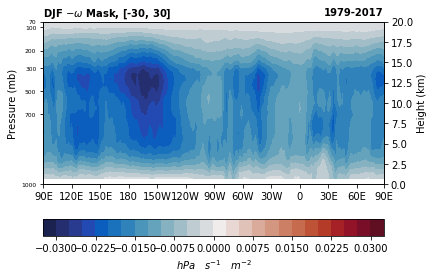

In [16]:
plotting.plot_contours_latHeight(vmin, vmax, zeros, contours, colormap, colorbar_label, left_title_up, right_title, 
                                 p_list, p_label, lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_up_djf, False)

<Figure size 21600x5400 with 0 Axes>

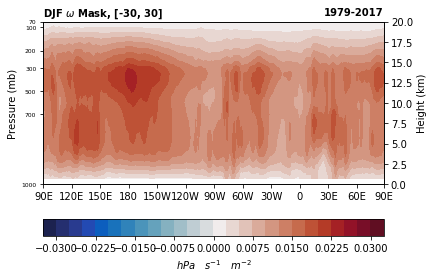

In [17]:
plotting.plot_contours_latHeight(vmin, vmax, zeros2, contours, colormap, colorbar_label, left_title_down, right_title, 
                                 p_list, p_label, lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_d_djf, False)